# Chasing the power of optimal length increase

(c) 2021 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

In [1]:
using LinearAlgebra, Distributions, Plots, Polynomials, LinearAlgebra, Turing, Printf
# Custom package
using Jevo, Jedi


# Set plotting style
Jedi.default_gr!()

┌ Info: Precompiling Jedi [b681c197-c997-42fd-b5bb-d7d7839f617e]
└ @ Base loading.jl:1278
┌ Warning: Package Jedi does not have Measures in its dependencies:
│ - If you have Jedi checked out for development and have
│   added Measures as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Jedi
└ Loading Measures into Jedi from project dependency, future warnings for Jedi are suppressed.


Plots.GRBackend()

In [2]:
@model function fit_exponent(x, y)
    sigma ~ truncated(Normal(0, 10^-6), 0, Inf)
    a ~ truncated(Normal(0, 1), 0, Inf)
    b ~ Normal(0, 1)
    _y = (x .* a) .+ b
     y ~ MvNormal(_y, sigma)
end

fit_exponent (generic function with 1 method)

## 1. Full Gamma Dynamics

First, let's have a look at the full $\Gamma$ dynamics. Therefore, we use the Kimura substitution probability to compute a distribution. Let's write down the rates for a match turning into a mismatch, $u_+(\Gamma, l)$, and the rate for a mismatch turning into a match, $u_-(\Gamma, l)$,

\begin{align}
u_+(\Gamma) &= \left(1 - \frac{\Gamma}{\epsilon l}\right) \left[p(F(\Gamma + \epsilon, l) - F(\Gamma, l) +\frac{\kappa}{N}\right],\\
u_-(\Gamma) &= \frac{\Gamma}{\epsilon l}\frac{1}{1-n} \left[p(F(\Gamma - \epsilon, l) - F(\Gamma, l) +\frac{\kappa}{N}\right],
\end{align}

where $p(s)$ is the Kimura substitution probability. The prefactors determine the probability of a match/mismatch mutating, which depends on the current state of the population. The extra prefactor $\frac{1}{1-n}$ comes from the consideration that a mismatch can mutate to another mismatch, which is not detectable on the level of quantitative traits. A similar factor is absent from the rate turning a match into am mismatch, since every mutation on a match leads to a mismatch. 

Then we use these rates to determine the probability distribution over the binding energies,

$$
Q(\Gamma, l) \propto \prod_{\Gamma^\prime=\epsilon}^\Gamma \frac{u_+(\Gamma-\epsilon, l)}{u_-(\Gamma, l)}.
$$

It might be more useful to compute the free fitness $\Psi$ instead, which is simply the log of the distribution,

$$
\Psi(\Gamma, l) \propto \sum_{\Gamma^\prime=\epsilon}^\Gamma \log\left[\frac{u_+(\Gamma-\epsilon, l)}{u_-(\Gamma, l)}\right].
$$

In [3]:
# Neutral Expectation
γ_0(n) = (n-1)/n

# Binding Threshold
γ_1(l, n, l_0) = γ_0(n) - l_0/l

# Binding probability
pb(γ, l, n, l_0, gap) = 1 / (1 + exp(gap * (l / l_0) * (γ - γ_1(l, n, l_0))))

# Fitness component for functional binding
F_b(γ, l, n, l_0, gap, f0) = f0 * pb(γ, l, n, l_0, gap)

# Fitness component of genomic constraint
F_c(l, l_0, fl) = - fl * l / l_0

# Total Fitness
F(γ, l, n, l_0, gap, f0, fl) = F_b(γ, l, n, l_0, gap, f0) + F_c(l, l_0, fl)

function kimura(s)
    if s^2 < 10^(-20)
        return 1
    elseif s < -10^7
        return 0
    else
        return s/(1 - exp(-s))
    end
end

# Substitution rate for trait changes
# (k, l) -> (k + 1, l)
up(γ, l, n, l_0, gap, f0, fl, κ) =  (1 - γ) * (kimura(F(γ + 1/l, l, n, l_0, gap, f0, fl) 
        - F(γ, l, n, l_0, gap, f0, fl)) + κ )

# (k, l) -> (k - 1, l)
um(γ, l, n, l_0, gap, f0, fl, κ) = γ * (1 - (n-2)/(n-1)) * (kimura(F(γ - 1/l, l, n, l_0, gap, f0, fl) 
        - F(γ, l, n, l_0, gap, f0, fl)) + κ )

# Free Fitness
function Ψ(l, n, l_0, gap, f0, fl, κ)
    # Start at neutral γ
    γ_i = floor(γ_0(n) * l) / l
    return collect(0:1/l:γ_i), push!(Float64[0], cumsum([log(up(γ - 1/l, l,  n, l_0, gap, f0, fl, κ) / um(γ, l,  n, l_0, gap, f0, fl, κ)) for γ in 1/l:1/l:γ_i])...)
    
end

Ψ (generic function with 1 method)

Using the free fitness, we can also compute the resulting distribution. 

In [4]:
# Probability distribution (from free Fitness)
function Q(l, n, l_0, gap, f0, fl, κ)
    x, y = Ψ(l, n, l_0, gap, f0, fl, κ)
    return x, exp.(y)
end



Q (generic function with 1 method)

Let's make some plots. Therefore we first determine some parameters.

In [5]:
gap = 5
l_0 = 5
f0 = 40l_0
fl = 1l_0
n = 4;

First we look at the fitness landscape and the free fitness as a sanity check, to determine that we actually implemented them correctly.

0.13333333333333333


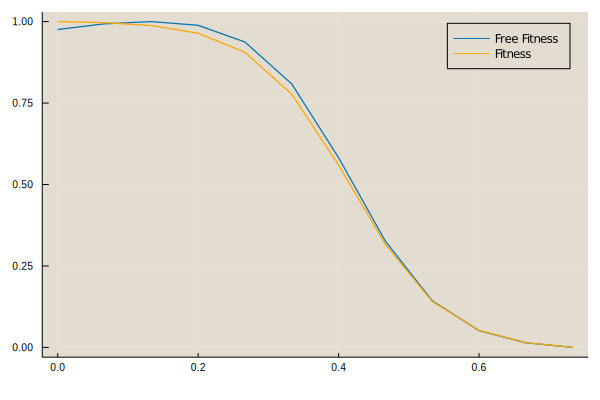

In [6]:
x, y = Ψ(15, n, l_0, gap, f0, fl, 0)
f = [F(γ, 15, n, l_0, gap, f0, fl) for γ in x]
println(x[argmax(y)])
plot(x, (y .- minimum(y))/(maximum(y)-minimum(y)), label="Free Fitness")

plot!(x, (f .- minimum(f))/(maximum(f)-minimum(f)), color="orange", label="Fitness")

Looking good so far. Let's have a look at a couple at a distribution and how it changes with some non-equilibrium.

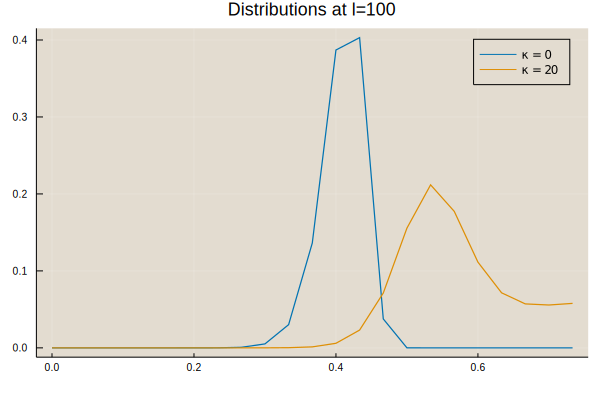

In [10]:
x1, y1 = Q(30, n, l_0, gap, f0, 0, 0)
x2, y2 = Q(30, n, l_0, gap, f0, 0, 20)
plot(x1, y1/sum(y1), title="Distributions at l=100", titlefontsize=12, label="κ = 0")
plot!(x2, y2/sum(y2), label="κ = 20")

We can nicely see how the distribution moves to less specificity and already gets a little mass at the neutral peak, which we have to consider later. Let's have a look at how the mean fitness looks for increasing length.

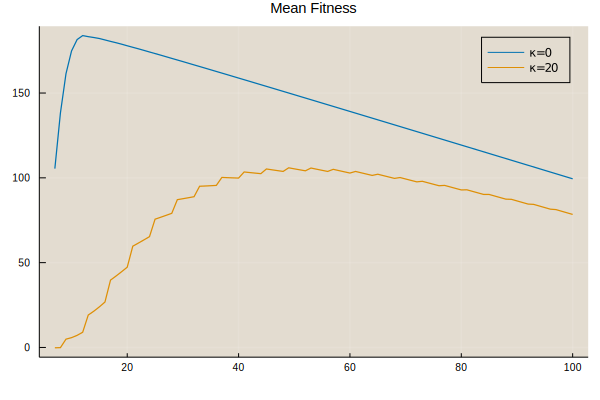

In [9]:
function mean_fitness(l, n, l_0, gap, f0, fl, κ)
    x, y = Q(l, n, l_0, gap, f0, fl, κ)
    y = y/sum(y)
    sum([F(γ, l, n, l_0, gap, f0, fl) for γ in x] .* y)
end

p_mf_0 = [mean_fitness(l, n, l_0, gap, f0, fl, 0) for l in 7:100]
p_mf_20 = [mean_fitness(l, n, l_0, gap, f0, fl, 20) for l in 7:100]
plot(7:100, p_mf_0, label="κ=0", title="Mean Fitness")
plot!(7:100, p_mf_20, label="κ=20")

As we expected, for increased non-equilibrium, it is not possible for some lengths to adapt. Now let's find the optimal length. Therefore we first compute some stuff. We start of with writing functions to compute the new intensive energy, where we have to consider the discreteness of the sequence, therefore the intensive energy changes for all types of length mutations (match/mismatch addition/removal). After computing the new intensive binding energy, we compute the selection coefficient of a length mutation at a given $\gamma$.

In [11]:
# (k,l) -> (k+1,l+1)
γ_pp(γ, l) = min((γ + 1/l)/(1 + 1/l), 1)

# (k,l) -> (k,l+1)
γ_pm(γ, l) = max(γ /(1 + 1/l), 0)

# (k,l) -> (k,l-1)
γ_mp(γ, l) = min(γ/(1 - 1/l), 1)

# (k,l) -> (k-1,l-1)
γ_mm(γ, l) = max((γ - 1/l)/(1 - 1/l), 0)


# selection coeffcients for length increase and decrease
# (k,l) -> (k+1,l+1)
s_pp(γ, l, n, l_0, gap, f0, fl) = 
    F(γ_pp(γ, l), l + 1, n, l_0, gap, f0, fl) - 
    F(γ, l, n, l_0, gap, f0, fl)

# (k,l) -> (k,l+1)
s_pm(γ, l, n, l_0, gap, f0, fl) = 
    F(γ_pm(γ, l), l + 1, n, l_0, gap, f0, fl) - 
    F(γ, l, n, l_0, gap, f0, fl)

# (k,l) -> (k-1,l-1)
s_mm(γ, l, n, l_0, gap, f0, fl) = 
 F(γ_mm(γ, l), l - 1, n, l_0, gap, f0, fl) - 
  F(γ, l, n, l_0, gap, f0, fl) 

# (k,l) -> (k,l-1)
s_mp(γ, l, n, l_0, gap, f0, fl) = 
 F(γ_mp(γ, l), l - 1, n, l_0, gap, f0, fl) - 
  F(γ, l, n, l_0, gap, f0, fl)

s_mp (generic function with 1 method)

Now that we can compute the selection coefficient, we compute the length substitution rates. For that we have to consider the difference of mutations that increase the length, where we add a random position, hence a match with probability $1/n$, and mutations where we decrease length, where the probability of removing a match depends on the intensive energy of the site, $(1-\gamma)$. The total length increase and decrease mutation rates are both averaged over the steady state distribution at that length, which comes from the assumption of separation of time scales.

In [12]:
function p_l_th(κ, n, l_0, gap, f0, fl, l_range=collect(40:200))
    vp = []
    vm = []
    for l in l_range
        x, y = Q(l, n, l_0, gap, f0, fl, κ)
        y = y/sum(y)
        s_mm_p = [s_pp(γ, l, n, l_0, gap, f0, fl) for γ in x]
        s_m_p = [s_pm(γ, l, n, l_0, gap, f0, fl) for γ in x]
        s_mm_m = [s_mm(γ, l, n, l_0, gap, f0, fl) for γ in x]
        s_m_m = [s_mp(γ, l, n, l_0, gap, f0, fl) for γ in x]
        v_mm_p = [(n-1)/n * kimura(s) for s in s_mm_p]
        v_m_p = [1/n * kimura(s) for s in s_m_p]
        v_mm_m = [ γ * kimura(s) for (s, γ) in zip(s_mm_m, x)]
        v_m_m = [(1 - γ)  * kimura(s) for (s, γ) in zip(s_m_m, x)]
        push!(vp, sum((v_m_p .+ v_mm_p) .* y))
        push!(vm, sum((v_mm_m .+ v_m_m) .* y))
    end
    return vp, vm, push!([0.01], (cumsum([log(vp[i]/vm[i+1]) for i in 1:length(vp)-1]).+0.01)...)
end

p_l_th (generic function with 2 methods)

Now let's have a look at the length increase and decrease substitution rates and the resulting effective fitness.

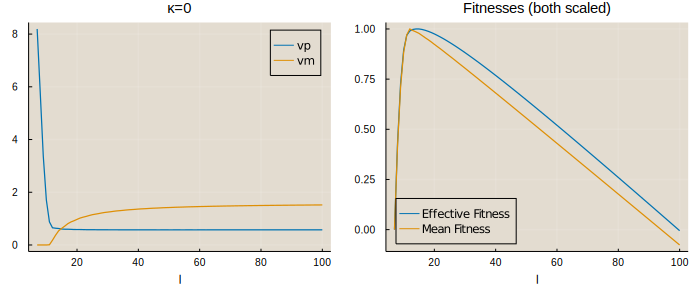

In [13]:
vp, vm, p_l = p_l_th(0, n, l_0, gap, f0, fl, collect(7:100))
p1 = plot(7:100, vp, label="vp", legend=:topright, title="κ=0", xlabel="l")
plot!(p1, 7:100, vm, label="vm")
p2 = plot(7:100, p_l ./ maximum(p_l), label="Effective Fitness", legend=:bottomleft, title="Fitnesses (both scaled)", xlabel="l")
mf = [mean_fitness(l, n, l_0, gap, f0, fl, 0) for l in 7:100]
plot!(p2, 7:100, (mf .- mf[1]) ./ (maximum(mf)-mf[1]) , label="Mean Fitness")
plot([p1, p2]..., size=(700, 300))

We can nicely see how the effective fitness is shifted to higher lengths due to the asymmetry of length mutations. When we consider optimal lengths in non-equilibrium, we have to consider that for smaller lengths sites will not able to adapt at all, and therefore be non-functional. We want to exclude these non-functional sites for now. Hence we use a function to find the minimal length of functional sites.

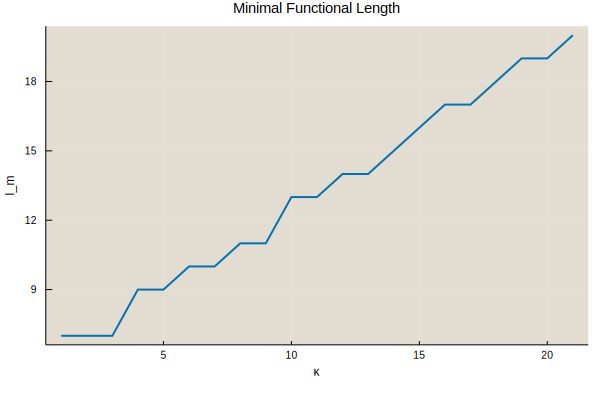

In [14]:
function min_func_length(n, l_0, gap, f0, fl, κ, l_arr=collect(7:100))
    gamma_max_list = zeros(length(l_arr))
    for (i, l) in enumerate(l_arr)
        x, y = Q(l, n, l_0, gap, f0, fl, κ) 
        gamma_max_list[i] = x[argmax(y)]
    end
    iterator = [[x, y] for (x, y) in zip(gamma_max_list, l_arr)]
    return findfirst( x -> x[1] < γ_1(x[2], n, l_0), iterator) + l_arr[1]-1
end

lmin_arr = [min_func_length(n, l_0, gap, f0, fl, κ) for κ in 0:20]
κ_arr = collect(0:20)

plot(
    κ_arr .+ 1, 
    lmin_arr,
    xlabel="κ",
    ylabel="l_m",
    title="Minimal Functional Length",
    linewidth=2
)

This looks nicely linear. Now let's look at the length mutation rates and the effective fitness for high non-equilibrium.

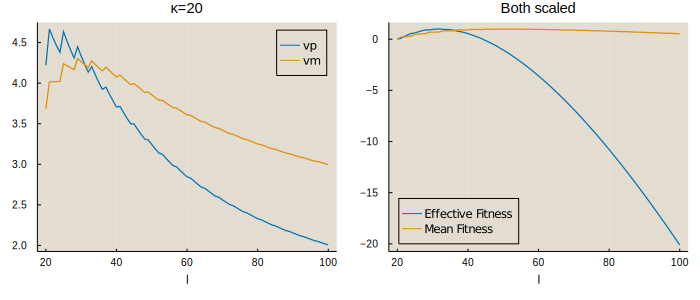

In [16]:
lm = min_func_length(n, l_0, gap, f0, fl, 20, collect(7:100))
l_arr = collect(lm:100)
vp, vm, p_l = p_l_th(20, n, l_0, gap, f0, fl, l_arr)


p1 = plot(l_arr, vp, label="vp", legend=:topright, title="κ=20", xlabel="l")
plot!(p1, l_arr, vm, label="vm")
p2 = plot(l_arr, p_l ./ maximum(p_l), label="Effective Fitness", legend=:bottomleft, title="Both scaled", xlabel="l")
mf = [mean_fitness(l, n, l_0, gap, f0, fl, 20) for l in l_arr]
plot!(p2, l_arr, (mf .- mf[1]) ./ (maximum(mf)-mf[1]) , label="Mean Fitness")
plot([p1, p2]..., size=(700, 300))

Now we have all the tools to compute the optimal length as a function of non-equilibrium.

In [17]:
function optimal_length_full(n, l_0, gap, f0, fl, κ_arr=collect(0:20))

    l_opt_th = []
    for κ in κ_arr
        lm = min_func_length(n, l_0, gap, f0, fl, κ)
        l_arr = collect(lm:100)
        p_l = p_l_th(κ, n, l_0, gap, f0, fl, l_arr)[3]
        l_opt = argmax(p_l) + lm - 1
        push!(l_opt_th, l_opt)
    end
    return l_opt_th
end

function plot_opt_length_full(n, l_0, gap, f0, fl, κ_arr=collect(0:20))
    l_opt_lin = optimal_length_full(n, l_0, gap, f0, fl, κ_arr)
    
    p_lin = plot(
        κ_arr, 
        l_opt_lin,
        xlabel="κ",
        ylabel="l_opt",
        title="f0=$(f0/l_0)l_0, fl=$(fl/l_0)l_0"
    )

    κ_arr_log = exp.(range(0, length=length(κ_arr), stop=log(κ_arr[end] + 1))) .- 1
    l_opt_log = optimal_length_full(n, l_0, gap, f0, fl, κ_arr_log)

    logx = log.(1 .+ κ_arr_log)
    logy = log.(l_opt_log)

    chn = sample(fit_exponent(logx[end-15:end], logy[end-15:end]), NUTS(0.75), 5_000)

    p_log = scatter(
        log.(κ_arr_log .+ 1), 
        log.(l_opt_log), 
        legend=:topleft, 
        xlabel="log(1+κ)",
        ylabel="log(l_opt)"
    )

    plot!(
        p_log, 
        log.(κ_arr_log .+ 1), 
        log.((κ_arr_log .+ 1).^(mean(chn[:a]))) .+ mean(chn[:b]), 
        linestyle=:dash,
        title=@sprintf "LogLog with slope %.3f" mean(chn[:a])
    )

    return plot([p_lin, p_log]..., size=(700, 300))
end

plot_opt_length_full (generic function with 2 methods)

In [50]:
gap = 10
l_0 = 10
f0 = 40l_0
fl = 1l_0
n = 4;

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfi

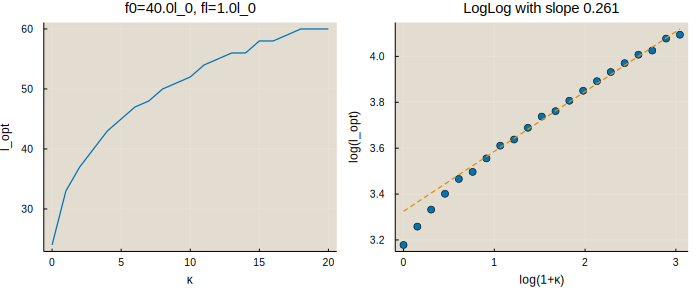

In [51]:
plot_opt_length_full(n, l_0, gap, f0, fl, collect(0:20))

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfi

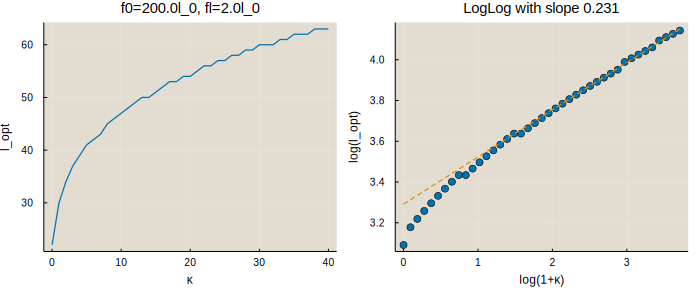

In [52]:
plot_opt_length_full(n, l_0, gap, 200l_0, 2l_0, collect(0:40))

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfi

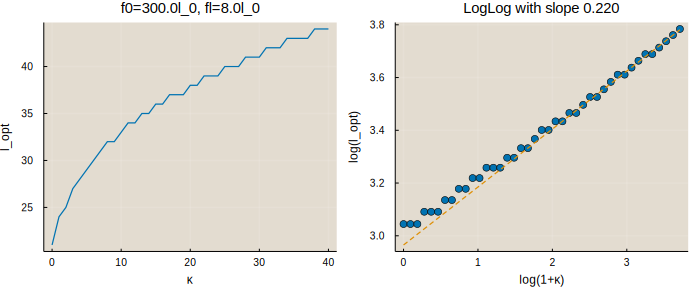

In [59]:
plot_opt_length_full(n, l_0, gap, 300l_0, 8l_0, collect(0:40))

# Only use the maximum of the energy distribution

Now we want to compare using the full distribution as we did above to simply using the maximum point of the distribution to compare. Therefore we first compute the maximum of the distribution.

In [21]:
function γ_star(l, n, l_0, gap, f0, fl, κ)
    x, y = Ψ(l, n, l_0, gap, f0, fl, κ) 
    max_ind = argmax(y)
    if max_ind == length(x)
        return x[end]
    elseif max_ind == 1
        return x[1]
    else
        f = Polynomials.fit(x[max_ind-1:max_ind+1], y[max_ind-1:max_ind+1], 2)
        return -f[1]/2f[2]
    end
end

γ_star (generic function with 1 method)

In [22]:
# (k,l) -> (k+1,l+1)
γ_pp(γ, l) = min((γ + 1/l)/(1 + 1/l), 1)

# (k,l) -> (k,l+1)
γ_pm(γ, l) = max(γ /(1 + 1/l), 0)

# (k,l) -> (k,l-1)
γ_mp(γ, l) = min(γ/(1 - 1/l), 1)

# (k,l) -> (k-1,l-1)
γ_mm(γ, l) = max((γ - 1/l)/(1 - 1/l), 0)


# selection coeffcients for length increase and decrease
# (k,l) -> (k+1,l+1)
s_pp(γ, l, n, l_0, gap, f0, fl) = 
    F(γ_pp(γ, l), l + 1, n, l_0, gap, f0, fl) - 
    F(γ, l, n, l_0, gap, f0, fl)

# (k,l) -> (k,l+1)
s_pm(γ, l, n, l_0, gap, f0, fl) = 
    F(γ_pm(γ, l), l + 1, n, l_0, gap, f0, fl) - 
    F(γ, l, n, l_0, gap, f0, fl)

# (k,l) -> (k-1,l-1)
s_mm(γ, l, n, l_0, gap, f0, fl) = 
 F(γ_mm(γ, l), l - 1, n, l_0, gap, f0, fl) - 
  F(γ, l, n, l_0, gap, f0, fl) 

# (k,l) -> (k,l-1)
s_mp(γ, l, n, l_0, gap, f0, fl) = 
 F(γ_mp(γ, l), l - 1, n, l_0, gap, f0, fl) - 
  F(γ, l, n, l_0, gap, f0, fl)

# substitution rates of length increase and decrease
v_pp(γ, l, n, l_0, gap, f0, fl) = γ_0(n) * kimura(s_pp(γ, l, n, l_0, gap, f0, fl))

v_pm(γ, l, n, l_0, gap, f0, fl) = (1 - γ_0(n)) * kimura(s_pm(γ, l, n, l_0, gap, f0, fl))

v_plus(γ, l, n, l_0, gap, f0, fl) = v_pp(γ, l, n, l_0, gap, f0, fl) + v_pm(γ, l, n, l_0, gap, f0, fl)

v_plus_star(l, n, l_0, gap, f0, fl, κ) = v_plus(γ_star(l, n, l_0, gap, f0, fl, κ), l, n, l_0, gap, f0, fl)

v_mm(γ, l, n, l_0, gap, f0, fl) = γ * kimura(s_mm(γ, l, n, l_0, gap, f0, fl)) 

v_mp(γ, l, n, l_0, gap, f0, fl) = (1 - γ) * kimura(s_mp(γ, l, n, l_0, gap, f0, fl))

v_minus(γ, l, n, l_0, gap, f0, fl) = v_mm(γ, l, n, l_0, gap, f0, fl) + v_mp(γ, l, n, l_0, gap, f0, fl) 

v_minus_star(l, n, l_0, gap, f0, fl, κ) = v_minus(γ_star(l, n, l_0, gap, f0, fl, κ), l, n, l_0, gap, f0, fl)

# Effective Fitness
F_eff(l, n, l_0, gap, f0, fl, κ, lmin) = sum([log(v_plus_star(l_, n, l_0, gap, f0, fl, κ)/
    v_minus_star(l_+1, n, l_0, gap, f0, fl, κ)) for l_  in lmin:l])

γ_star_list(n, l_0, gap, f0, fl, κ, l_max=200) = [l > 10 ? γ_star(l, n, l_0, gap, f0, fl, κ) : missing  for l in 1:l_max]

function l_star(n, l_0, gap, f0, fl, κ, l_max=200) 
    gstarlist = γ_star_list(n, l_0, gap, f0, fl, κ, l_max)
    funct_pos_list = []
    for l in 1:l_max
        if (~ismissing(gstarlist[l])) && (gstarlist[l] < γ_1(l, n, l_0))
            push!(funct_pos_list, l)
        end
    end
    γ_fun_list = gstarlist[funct_pos_list]
    lm = funct_pos_list[1]
    f_list = zeros(l_max)

    f_list[lm+1:l_max] = cumsum([log(v_plus(gstarlist[i-1], i-1, n, l_0, gap, f0, fl)/
                v_minus(gstarlist[i], i, n, l_0, gap, f0, fl)) for i in lm+1:l_max])
    max_ind = argmax(f_list)
        
    fmax = f_list[max_ind]
    lst = max_ind
    return gstarlist[max_ind], γ_fun_list, f_list, fmax, lst, lm
end

l_star (generic function with 2 methods)

In [23]:
function p_l_star(κ, n, l_0, gap, f0, fl, l_range=collect(20:250))
    vp = []
    vm = []
    for l in l_range
        γ = γ_star(l, n, l_0, gap, f0, fl, κ)
        s_mm_p = s_pp(γ, l, n, l_0, gap, f0, fl) 
        s_m_p = s_pm(γ, l, n, l_0, gap, f0, fl)
        s_mm_m = s_mm(γ, l, n, l_0, gap, f0, fl)
        s_m_m = s_mp(γ, l, n, l_0, gap, f0, fl)
        v_mm_p = γ_0(n) * kimura(s_mm_p)
        v_m_p = (1 - γ_0(n)) * kimura(s_m_p)
        v_mm_m = γ * kimura(s_mm_m)
        v_m_m = (1 - γ)  * kimura(s_m_m)
        push!(vp, v_m_p + v_mm_p)
        push!(vm, v_mm_m .+ v_m_m)
    end
    return vp, vm, push!([0.01], (cumsum([log(vp[i-1]/vm[i]) for i in 2:length(vp)]).+0.01)...)
end

p_l_star (generic function with 2 methods)

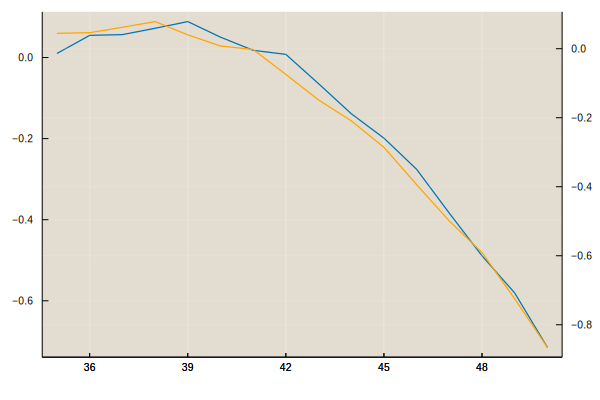

In [26]:
κ = 40
lm = min_func_length(n, l_0, gap, f0, fl, κ)
plot(lm:50, p_l_star(κ, n, l_0, gap, f0, fl, collect(lm:50))[3])
plot!(twinx(), lm:50, [F_eff(l, n, l_0, gap, f0, fl, κ, lm) for l in lm:50], color = "orange")

In [27]:
function optimal_length_star(n, l_0, gap, f0, fl, κ_arr=collect(0:20))
    l_opt_star = []
    for κ in κ_arr
        push!(l_opt_star, l_star(n, l_0, gap, f0, fl, κ)[end-1])
    end
    return l_opt_star
end

function plot_opt_length_star(n, l_0, gap, f0, fl, κ_arr=collect(0:20))
    l_opt_lin = optimal_length_star(n, l_0, gap, f0, fl, κ_arr)
    
    p_lin = plot(
        κ_arr, 
        l_opt_lin,
        xlabel="κ",
        ylabel="l_opt",
        title="f0=$(f0/l_0)l_0, fl=$(fl/l_0)l_0"
    )

    κ_arr_log = exp.(range(0, length=length(κ_arr), stop=log(κ_arr[end] + 1))) .- 1
    l_opt_log = optimal_length_star(n, l_0, gap, f0, fl, κ_arr_log)
    

    logx = log.(1 .+ κ_arr_log)
    logy = log.(l_opt_log)

    chn = sample(fit_exponent(logx[end-15:end], logy[end-15:end]), NUTS(0.75), 5_000)

    p_log = scatter(
        log.(κ_arr_log .+ 1), 
        log.(l_opt_log), 
        legend=:topleft, 
        xlabel="log(1+κ)",
        ylabel="log(l_opt)"
    )

    plot!(
        p_log, 
        log.(κ_arr_log .+ 1), 
        log.((κ_arr_log .+ 1).^(mean(chn[:a]))) .+ mean(chn[:b]), 
        linestyle=:dash,
        title=@sprintf "LogLog with slope %.3f" mean(chn[:a])
    )
    
    
    return plot([p_lin, p_log]..., size=(900, 450))
end

plot_opt_length_star (generic function with 2 methods)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfi

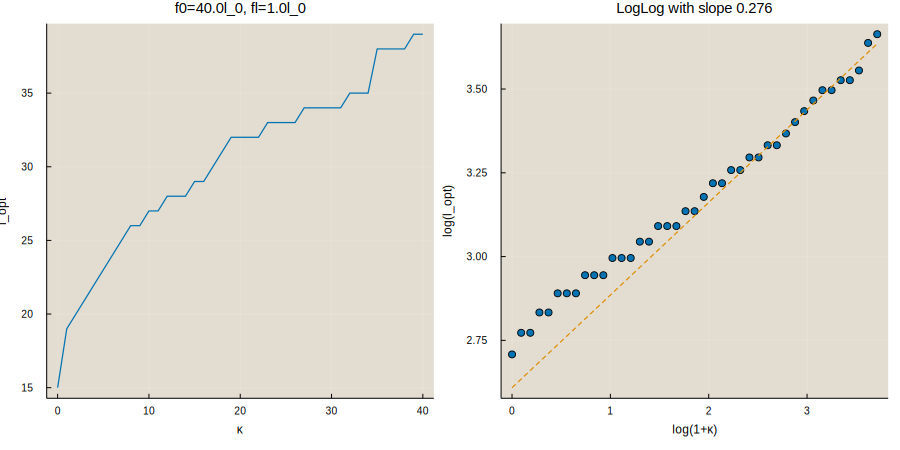

In [28]:
plot_opt_length_star(n, l_0, gap, 40l_0, l_0, collect(0:40))

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfi

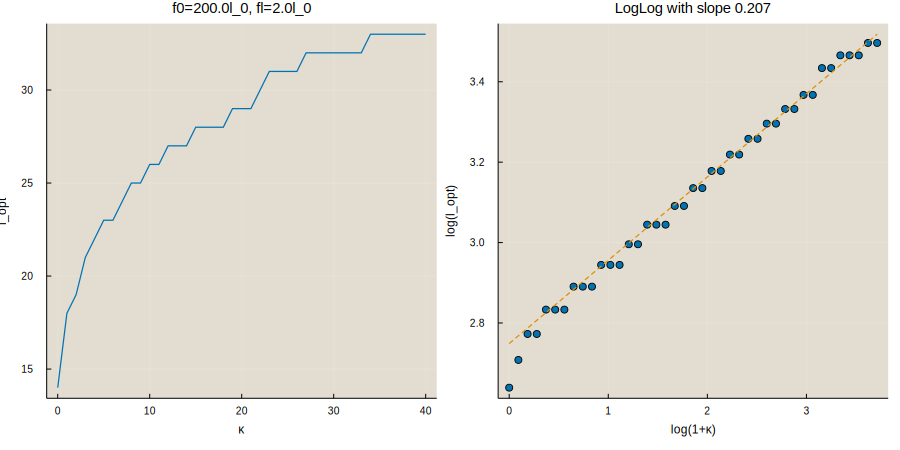

In [31]:
plot_opt_length_star(n, l_0, gap, 200l_0, 2fl, collect(0:40))

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfi

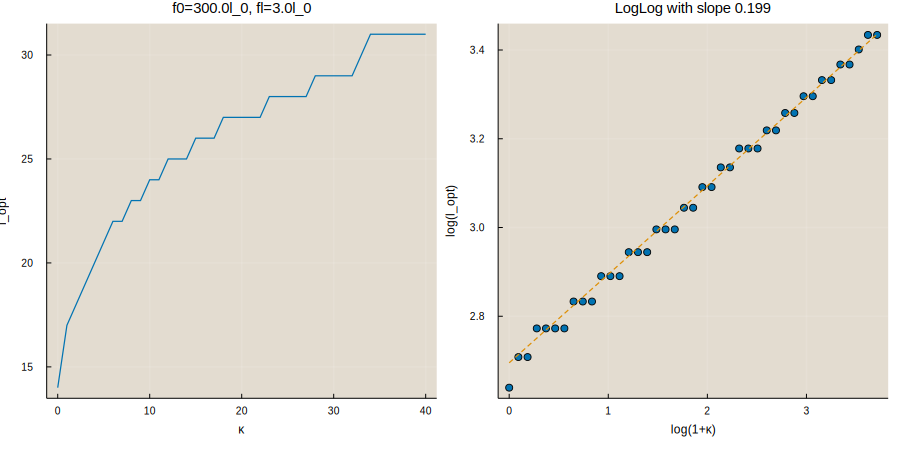

In [32]:
plot_opt_length_star(n, l_0, gap, 300l_0, 3fl, collect(0:40))

## Gamma Star

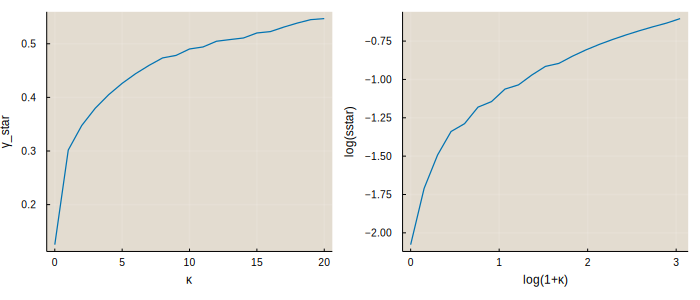

In [33]:
κ_arr = collect(0:20)
κ_log = exp.(range(0, length=length(κ_arr), stop=log(κ_arr[end] + 1))) .- 1

p_lin = plot(
    κ_arr, 
    [l_star(n, l_0, gap, f0, fl, κ)[1] for κ in κ_arr],
    xlabel="κ",
    ylabel="γ_star"
)
p_log = plot(
    log.(1 .+ κ_log), 
    [log(l_star(n, l_0, gap, f0, fl, κ)[1]) for κ in κ_log],
    xlabel="log(1+κ)",
    ylabel="log(sstar)"
)

plot([p_lin, p_log]..., size=(700, 300))

## S_Star

In [34]:
sstar(l, n, l_0, gap, f0, fl, κ) = F(γ_star(l, n, l_0, gap, f0, fl, κ) - 1/l, l, n, l_0, gap, f0, fl) - F(γ_star(l, n, l_0, gap, f0, fl, κ), l, n, l_0, gap, f0, fl)


sstar (generic function with 1 method)

In [61]:
function plot_sstar(n, l_0, gap, f0, fl, κ_arr=collect(0:30); return_plot=true)

    l_opt = optimal_length_star(n, l_0, gap, f0, fl, κ_arr)
    star = [sstar(l, n, l_0, gap, f0, fl, κ) for (l, κ) in zip(l_opt, κ_arr)]

    κ_log = exp.(range(0, length=length(κ_arr), stop=log(κ_arr[end] + 1))) .- 1
    star_log = [sstar(l, n, l_0, gap, f0, fl, κ) for (l, κ) in zip(l_opt, κ_log)]

    logx = log.(1 .+ κ_log)
    logy = log.(star_log)

    chn = sample(fit_exponent(logx[2:end], logy[2:end]),NUTS(0.65), 3_000)
    if return_plot
        p_lin = plot(
            κ_arr, 
            star,
            xlabel="κ",
            ylabel="s_star",
            title="f0=$(f0/l_0)l_0, fl=$(fl/l_0)l_0"
        )
        p_log = plot(log.(1 .+ κ_log), log.(star_log))
        plot!(
            p_log, 
            log.(1 .+ κ_log), 
            log.((1 .+ κ_log) .^(mean(chn[:a]))) .+ mean(chn[:b]),
            linestyle=:dash,
            xlabel="log(1+κ)",
            ylabel="log(s_star)",
            title=@sprintf "LogLog with slope %.3f" mean(chn[:a])


        )

        return plot([p_lin, p_log]..., size=(900, 450))
    else
        return chn
    end
end

plot_sstar (generic function with 3 methods)

In [64]:
s = []
for (f0, fl) in zip([40, 100, 200, 300], [1, 1.5, 2, 3])
    push!(s, mean(plot_sstar(n, l_0, gap, f0*l_0, fl*l_0, return_plot=false)[:a]))
end
println(s)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfi

Any[0.9216546731289336, 0.909668423963915, 0.8974901504931337, 0.8909789233628159]


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfi

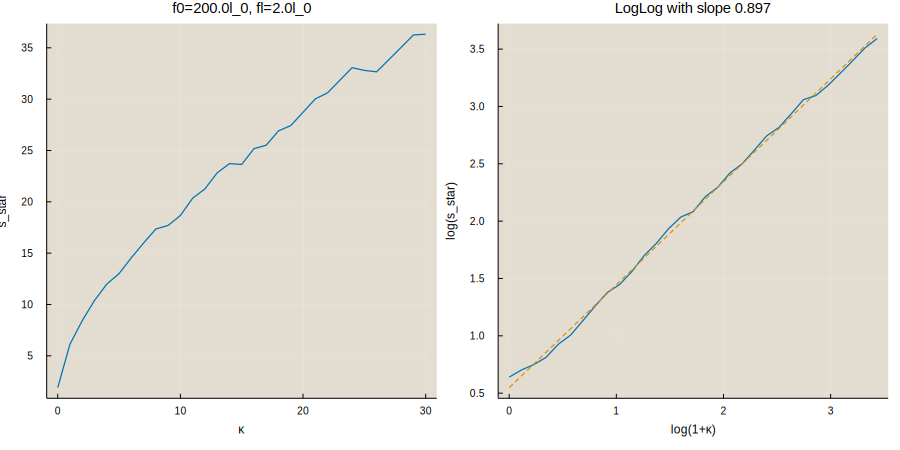

In [65]:
plot_sstar(n, l_0, gap, 200l_0, 2l_0)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tomroschinger/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfi

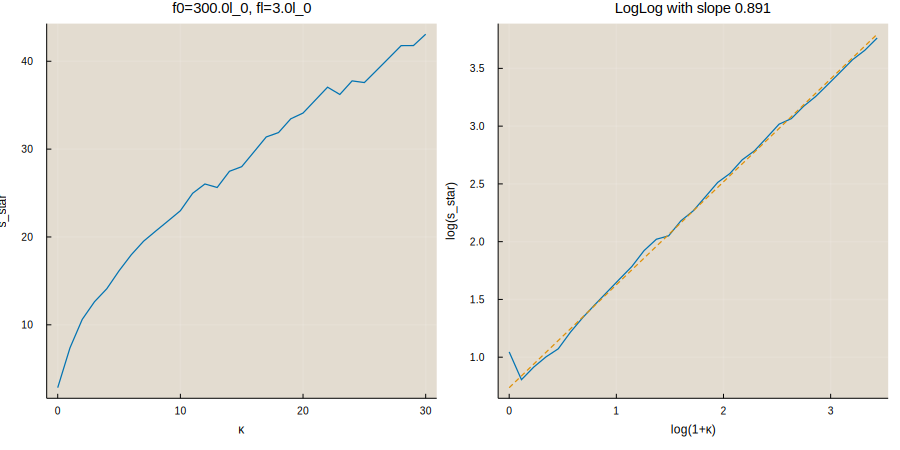

In [66]:
plot_sstar(n, l_0, gap, 300l_0, 3l_0)